In [41]:
import torch 
from collections.abc import Iterable
from datasets import load_dataset, list_datasets, concatenate_datasets

# Model and tokenizer from 🤗 Transformers
from transformers import AutoModelForSequenceClassification, \
    BertForSequenceClassification, BertTokenizerFast, AutoModel, AutoTokenizer

# Code you will write for this assignment
from train_model import init_model, preprocess_dataset, init_trainer, preprocess_dataset_hatexplain
from test_model import init_tester

import numpy as np
import pickle

In [42]:
hate_speech = load_dataset("hate_speech_offensive")

Found cached dataset hate_speech_offensive (/Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)


  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
hatexplain = load_dataset("hatexplain")

Found cached dataset hatexplain (/Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
hatexplain['train']['annotators'][0]

{'label': [0, 2, 2],
 'annotator_id': [203, 204, 233],
 'target': [['Hindu', 'Islam'],
  ['Hindu', 'Islam'],
  ['Hindu', 'Islam', 'Other']]}

In [45]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
labels = 'original'

hate_speech["train"] = preprocess_dataset(hate_speech["train"], tokenizer, labels)
hatexplain["train"] = preprocess_dataset_hatexplain(hatexplain["train"], tokenizer, labels)
hatexplain["validation"] = preprocess_dataset_hatexplain(hatexplain["validation"], tokenizer, labels)
hatexplain["test"] = preprocess_dataset_hatexplain(hatexplain["test"], tokenizer, labels)

Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-bbe824bcb2403eb5.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-0110407a481ff540.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-1311d9b2a263b60a.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-7b8775d38c6a3de0.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/

In [47]:
bert_dataset = concatenate_datasets([hatexplain['train'], hatexplain['validation'], hatexplain['test'], hate_speech['train']])

split = bert_dataset.train_test_split(.2, seed=3463)
split_2 = split["train"].train_test_split(.125, seed=3463)
split["train"] = split_2["train"]
split["val"] = split_2["test"]

Loading cached split indices for dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-f735886b7095c199.arrow and /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-e35b6bba8142ed0d.arrow


In [48]:
import collections
counter = collections.Counter(np.array(split['train']['labels']))
counter

Counter({0: 5169, 2: 6725, 1: 18913})

In [49]:
def read_result(file):
    with open(file, 'rb') as f:
        object = pickle.load(f)
    return object

In [50]:
obj = read_result('test_results_hatexplain.p')

In [51]:
texts = np.array(split['test']['tweet'])
true_labels = np.array(split['test']['labels'])
len(true_labels)

8803

In [52]:
pred_labels = obj[0].argmax(axis=1)
len(pred_labels)

8803

In [53]:
np.set_printoptions(suppress=True)

cm = np.zeros((3,3))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm[i][j] = int(sum((true_labels == i) & (pred_labels == j)))
cm

array([[ 843.,  227.,  368.],
       [ 122., 4700.,  613.],
       [ 163.,  700., 1067.]])

Text(50.722222222222214, 0.5, 'true')

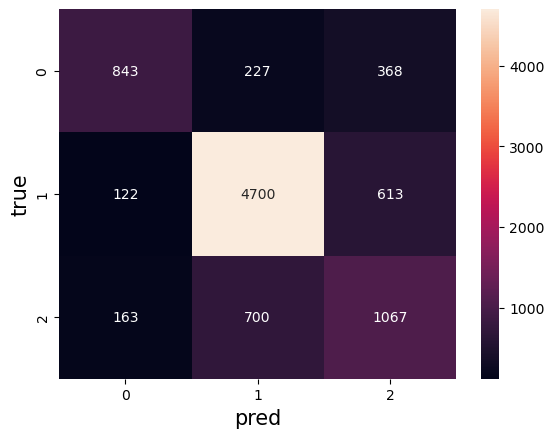

In [54]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [55]:
demo_arr = np.array(split['test']['demo_props'])
demo_l = []

for d in demo_arr:
    if any(d>0.6):
        demo_l.append(np.argmax(d))
    else:
        demo_l.append(-1)
demos = np.array(demo_l)
len(demos)

8803

In [56]:
np.set_printoptions(suppress=True)

cm_aa, cm_his, cm_as, cm_wh = np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm_aa[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 0)))
        cm_his[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 1)))
        cm_as[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 2)))
        cm_wh[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 3)))

Text(50.722222222222214, 0.5, 'true')

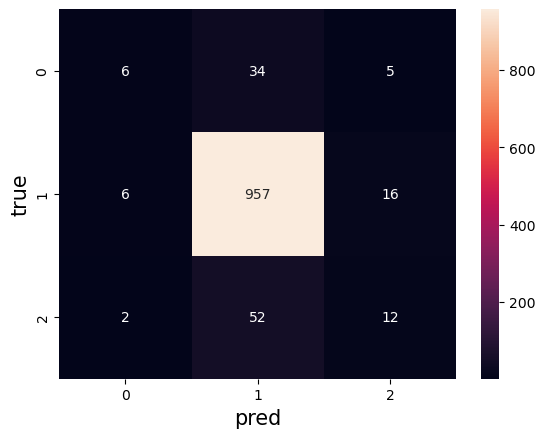

In [57]:
sn.heatmap(cm_aa, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

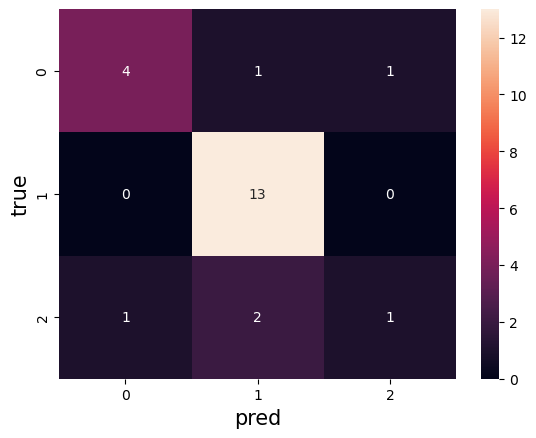

In [58]:
sn.heatmap(cm_his, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

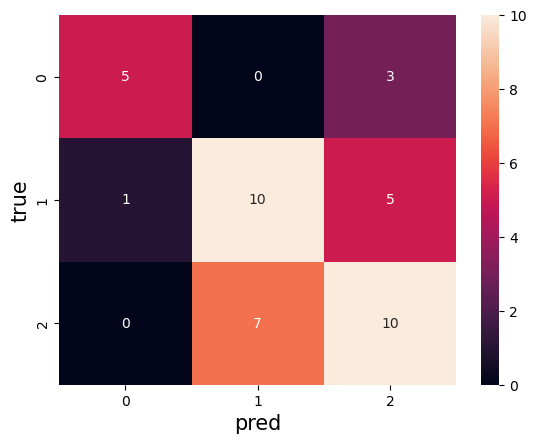

In [59]:
sn.heatmap(cm_as, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

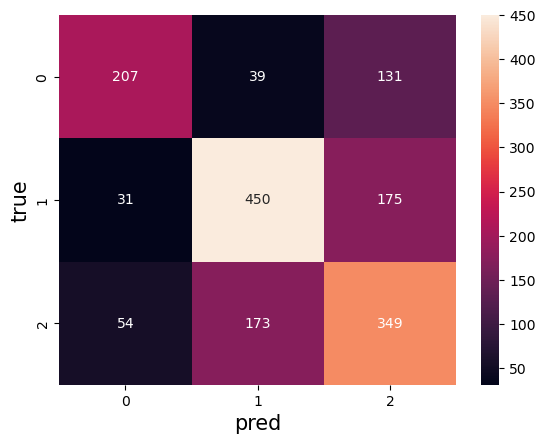

In [60]:
sn.heatmap(cm_wh, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15